<div align='right'>Денис Башинский, проект модуля "Компьютерное зрение"</div>

# Определение возраста покупателей

## Исследовательский анализ данных

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
#настроим параметры отображения графиков
sns.set(rc={"figure.figsize": (15, 10)})
sns.set_style("whitegrid")

Загрузим датасет и посмотрим на основные параметры выборки:

In [13]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

display(labels.head())
display(labels.info())
display(labels.shape)

Found 7591 validated image filenames.


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

(7591, 2)

У нас есть 7591 фотография. Этого должно быть достаточно, чтобы нейросеть адекватно обучилась.  

Построим график распределения возраста:

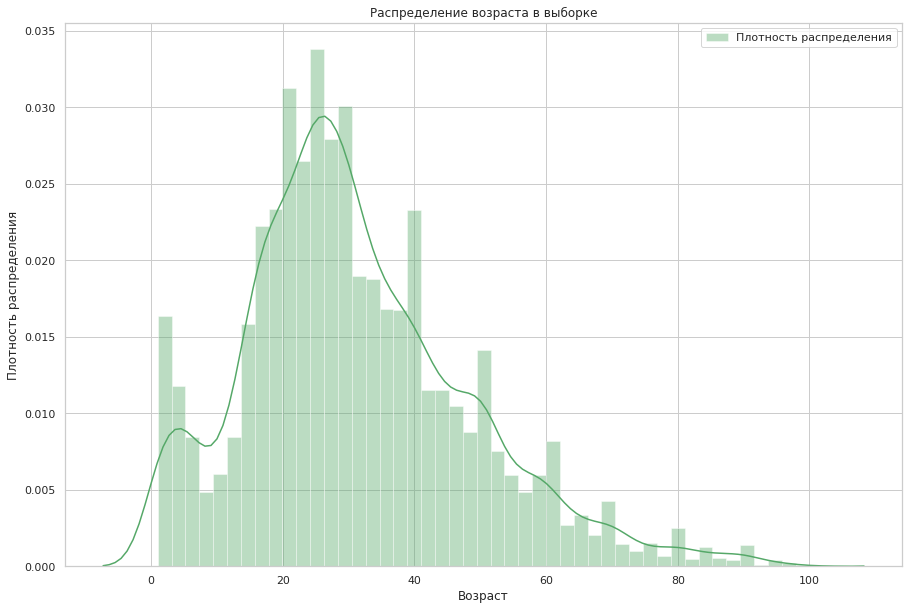

In [15]:
sns.distplot(labels['real_age'], color='g', label='Плотность распределения')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Плотность распределения')
plt.legend()

plt.show()

Медианное значение возраста покупателей находится где-то около 26 лет, при этом данные скошены вправо: пожилых покупателей не так много по сравнению с наиболее активными финансово людьми (примерно 20-40 лет).

Посмотрим на первые 15 фото из выборки:

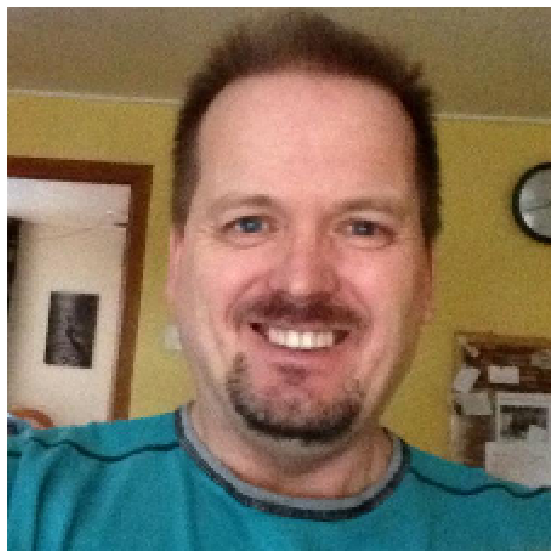

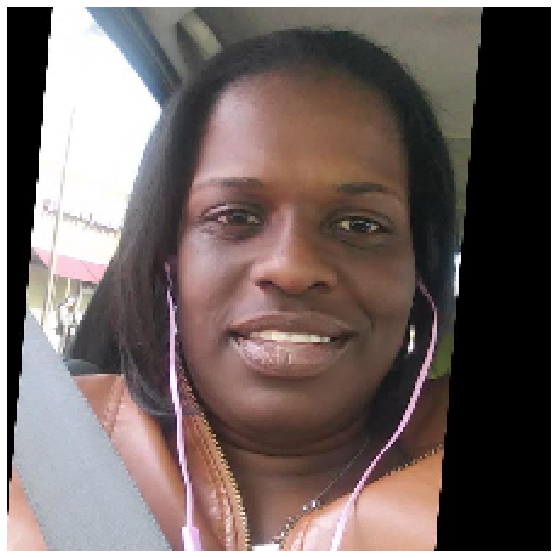

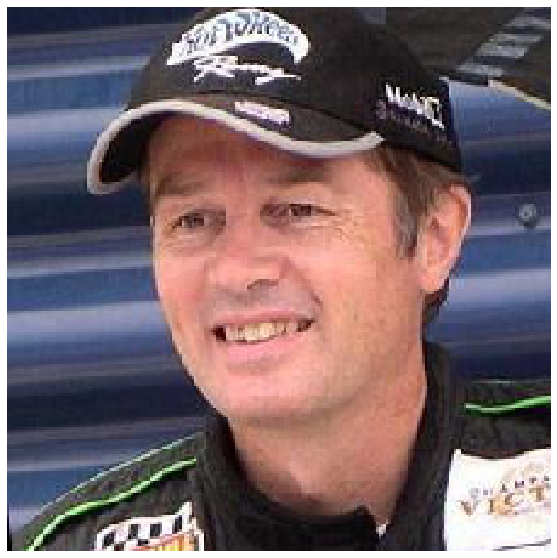

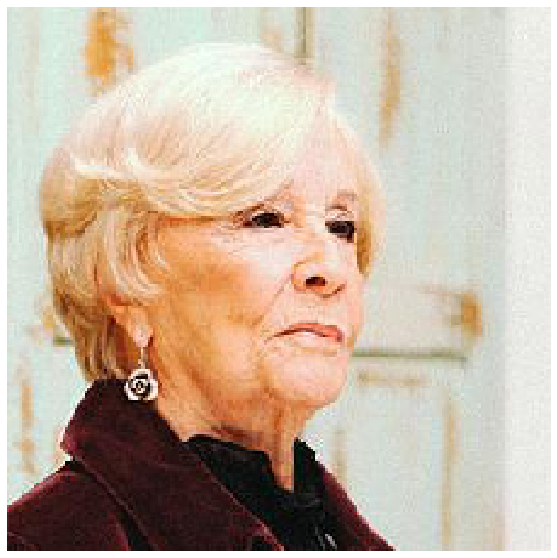

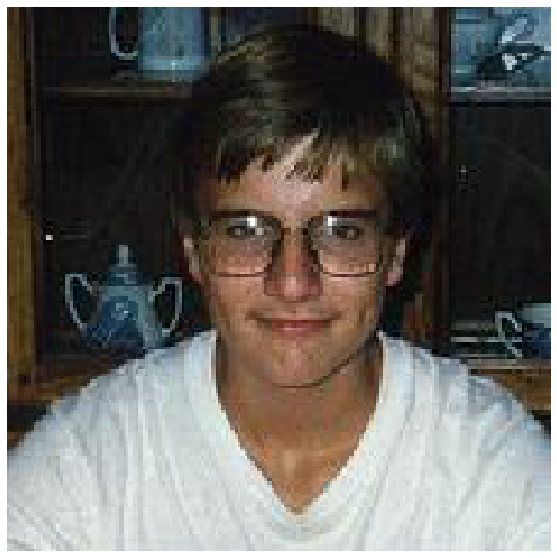

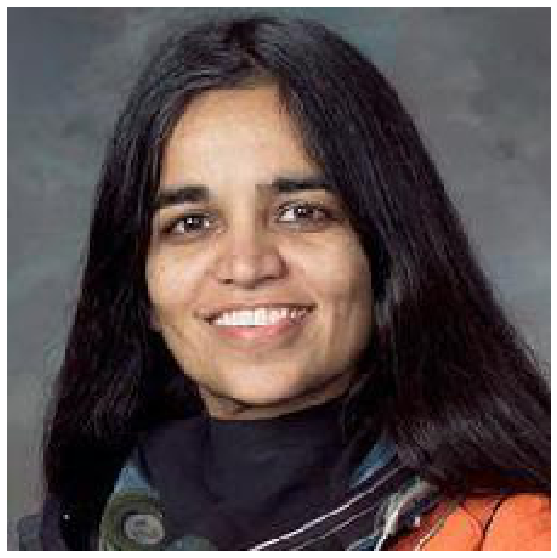

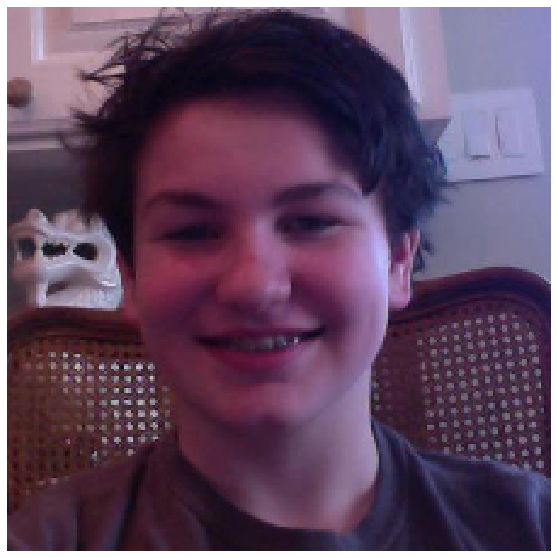

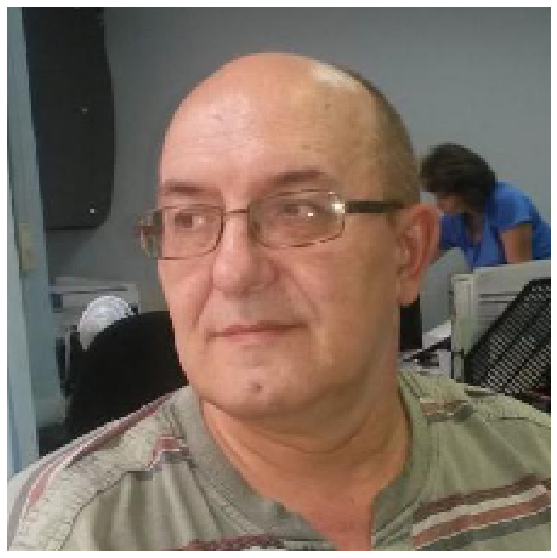

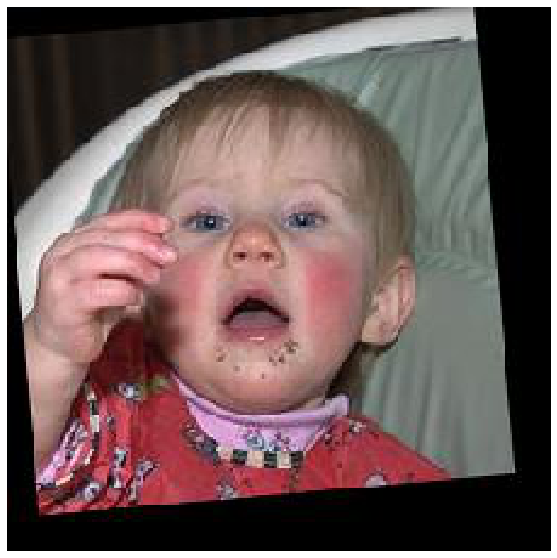

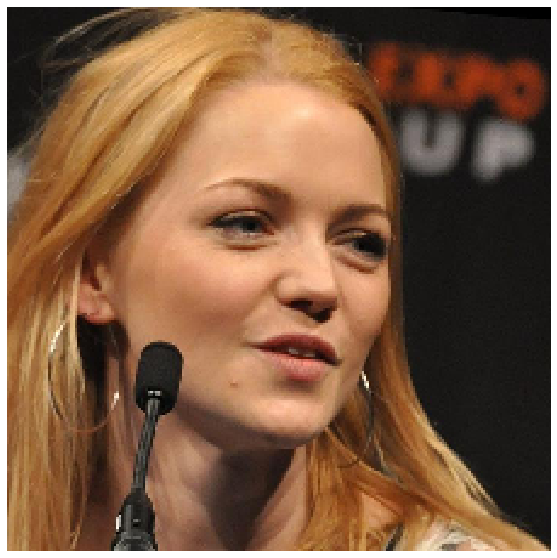

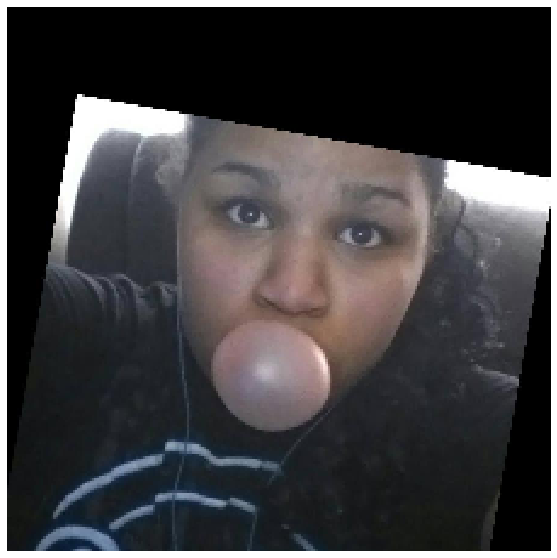

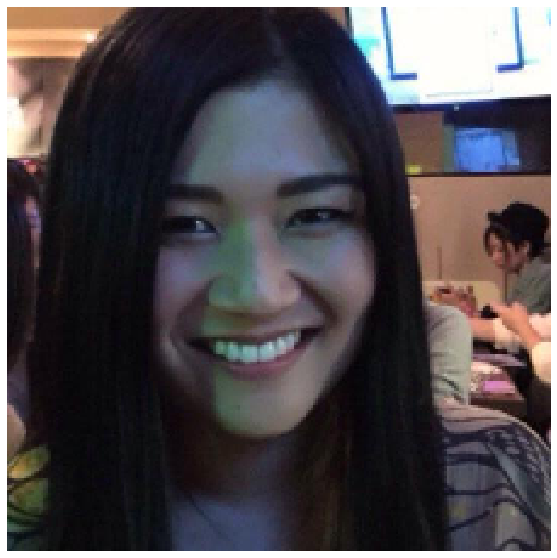

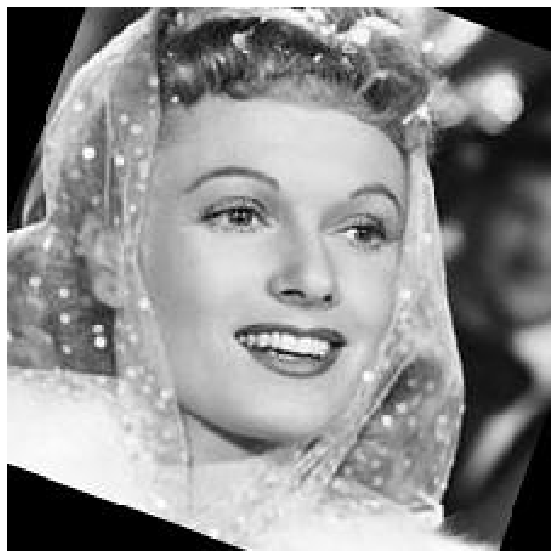

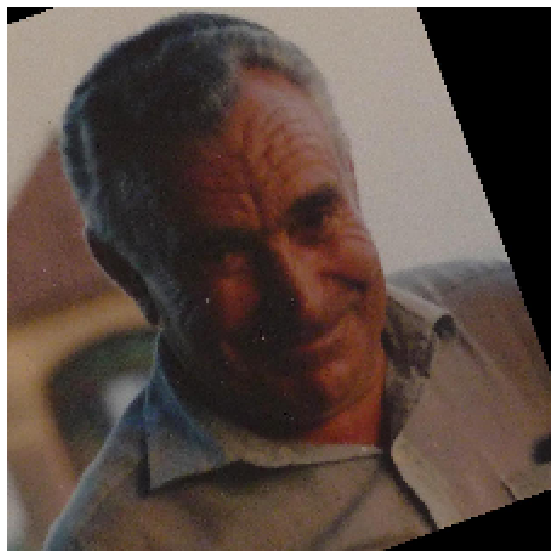

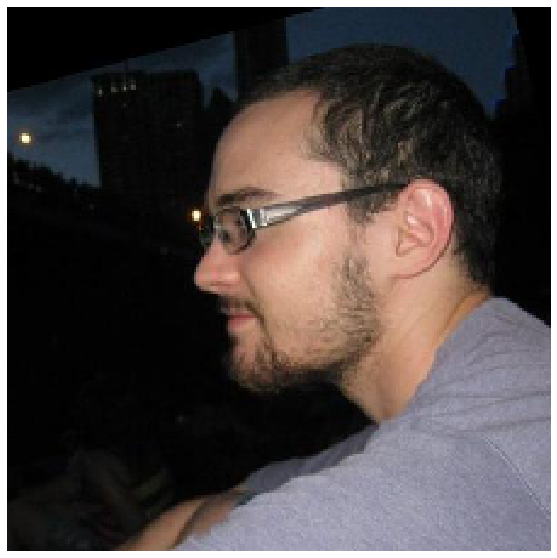

In [25]:
for i in range(15):
    plt.imshow(train_gen_flow[0][0][i])
    plt.axis('off')
    #plt.title('Возраст: {}'.format(labels['real_age'][i]))
    plt.show()

Все фотографии очень разные, их объединяет то, что они сделаны в разных условиях.

Пока можно сказать, что наша нейросеть лучше будет определять возраст для тех возрастных категорий, чьих фотографий в выборке больше.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import tensorflow as tf
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


labels = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):
    

    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.,
                                       horizontal_flip=True)   

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
    

    return train_gen_flow
    

def load_test(path):
    
    validation_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )
    
    val_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    
    return val_gen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, 
                  loss='mse', metrics=['mae'])
   

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model


```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2021-04-25 18:40:19.240356: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-25 18:40:19.528792: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 239.2372 - mae: 11.0674 - val_loss: 924.1542 - val_mae: 25.5871
Epoch 2/10
178/178 - 37s - loss: 73.4164 - mae: 6.4945 - val_loss: 788.5305 - val_mae: 23.0713
Epoch 3/10
178/178 - 38s - loss: 51.1271 - mae: 5.4463 - val_loss: 294.3524 - val_mae: 12.6562
Epoch 4/10
178/178 - 38s - loss: 35.9849 - mae: 4.5586 - val_loss: 123.3908 - val_mae: 8.5526
Epoch 5/10
178/178 - 38s - loss: 25.8555 - mae: 3.9233 - val_loss: 83.0560 - val_mae: 6.8627
Epoch 6/10
178/178 - 38s - loss: 22.2789 - mae: 3.5887 - val_loss: 113.5594 - val_mae: 8.4043
Epoch 7/10
178/178 - 38s - loss: 18.2158 - mae: 3.2886 - val_loss: 63.8363 - val_mae: 5.9177
Epoch 8/10
178/178 - 38s - loss: 16.7182 - mae: 3.1320 - val_loss: 75.3969 - val_mae: 6.7369
Epoch 9/10
178/178 - 38s - loss: 12.8122 - mae: 2.7375 - val_loss: 71.2973 - val_mae: 6.2797
Epoch 10/10
178/178 - 38s - loss: 11.1916 - mae: 2.5390 - val_loss: 70.4457 - val_mae: 6.2732
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 70.4457 - mae: 6.2732
Test MAE: 6.2732

```

## Анализ обученной модели

Для обучения модели была выбрана архитектура `ResNet-50`. С ее помощью удалось достичь значения **mae 6.27**. 

При этом скорость ее обучения лучше, чем у сверточных (LeNet) и полносвязных сетей: среднее время на эпоху около 75 секунд. 

Такой результат довольно хорош: в среднем модель будет ошибаться на 6 лет, что не особо критично, так как в пределах 10 лет людей можно относить к одной возрастной группе, таким образом, рекомендации будут почти безошибочными. Что касается алкоголя, лучшей системы, чем проверка документов, пока не существует.